In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from EvidentialTrainer import EvidentialTrainer
from FullyConnectedModel import EvidentialRegression

In [2]:
learning_rate = 1e-3
lambda_coef = torch.Tensor([1e-2])
epsilon = 1e-2
maxi_rate = 1e-4
batch_size = 64

In [3]:
def plot_predictions(x_train, y_train, x_test, y_test, y_pred, n_stds=4, kk=0):
    x_test = x_test[:, 0]
    mu, v, alpha, beta = y_pred
#    mu = mu[:, 0]
    var = np.sqrt(beta / (v * (alpha - 1)))
#    var = np.minimum(var, 1e3)[:, 0]  # for visualization
    var = np.minimum(var, 1e3)  # for visualization

    plt.figure(figsize=(5, 3), dpi=200)
    plt.scatter(x_train, y_train, s=1., c='#463c3c', zorder=0, label="Train")
    plt.plot(x_test, y_test, 'r--', zorder=2, label="True")
    plt.plot(x_test, mu, color='#007cab', zorder=3, label="Pred")
    plt.plot([-4, -4], [-150, 150], 'k--', alpha=0.4, zorder=0)
    plt.plot([+4, +4], [-150, 150], 'k--', alpha=0.4, zorder=0)
    for k in np.linspace(0, n_stds, 4):
        plt.fill_between(
            x_test, (mu - k * var), (mu + k * var),
            alpha=0.3,
            edgecolor=None,
            facecolor='#00aeef',
            linewidth=0,
            zorder=1,
            label="Unc." if k == 0 else None)
    plt.gca().set_ylim(-15, 15)
    plt.gca().set_xlim(-7, 7)
    plt.legend(loc="upper left")

In [44]:
def standardize(data):
    mu = data.mean(axis=0, keepdims=1)
    scale = data.std(axis=0, keepdims=1)
    scale[scale < 1e-10] = 1.0

    data = (data - mu) / scale
    return data, mu, scale

# Synthetic Datasets
## Dataset 1

In [83]:
def generate_d1():
    train_size, test_size = 80, 20
    s1, e1 = -4, -1
    s2, e2 = 1, 4
    ts, te = -6, 6
    std = 0.25
    x_train = np.concatenate([np.linspace(s1, e1, (train_size + 1)//2), np.linspace(s2, e2, train_size//2)])
    noise = np.random.normal(scale=std, size=train_size)
    y_train = 0.1*x_train**3 + noise
    
    x_test = np.linspace(ts, te, test_size)
    y_test = 0.1*x_test**3

    return (x_train, y_train), (x_test, y_test)

In [84]:
(x_train_d1, y_train_d1), (x_test_d1, y_test_d1) = generate_d1()

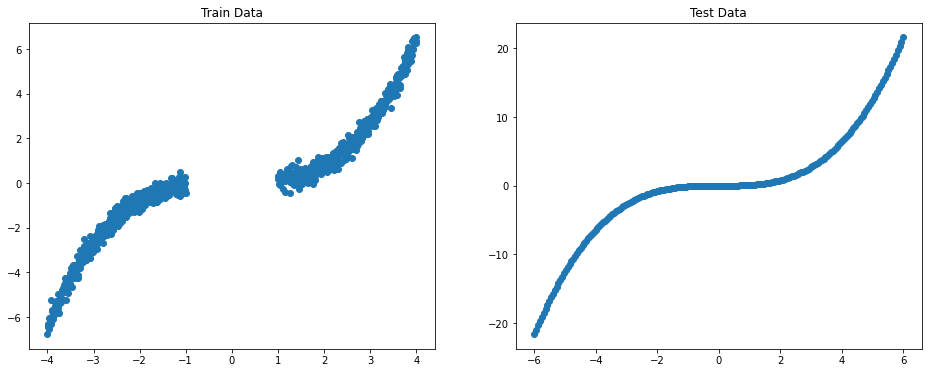

In [85]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

ax1.scatter(x_train_d1, y_train_d1)
ax1.set_title("Train Data")

ax2.scatter(x_test_d1, y_test_d1)
ax2.set_title("Test Data")

plt.show()

In [86]:
d1_model = EvidentialRegression(1)
d1_trainer = EvidentialTrainer(d1_model, learning_rate=learning_rate)
rmse, nll = d1_trainer.train(
    torch.from_numpy(x_train_d1).unsqueeze(-1).float(),
    torch.from_numpy(y_train_d1).float(),
    torch.from_numpy(x_test_d1).unsqueeze(-1).float(),
    torch.from_numpy(y_test_d1).float(),
    y_train_scale_d1.item(),
    iters=1000,
    batch_size=batch_size,
    verbose=True
)

[0]  RMSE: 26.1020 	 NLL: 6.3758 	 loss: 5.3611 	 reg_loss: 27.9705 	 lambda: 0.00
[100]  RMSE: 17.0775 	 NLL: 4.0666 	 loss: 3.3513 	 reg_loss: 8.4217 	 lambda: 0.04
[200]  RMSE: 16.6045 	 NLL: 4.0666 	 loss: 3.6086 	 reg_loss: 7.2163 	 lambda: 0.06
[300]  RMSE: 16.0690 	 NLL: 3.6045 	 loss: 2.9960 	 reg_loss: 5.4825 	 lambda: 0.08
[400]  RMSE: 14.9518 	 NLL: 3.4913 	 loss: 2.8916 	 reg_loss: 4.7585 	 lambda: 0.09
[500]  RMSE: 12.9475 	 NLL: 2.8043 	 loss: 2.1344 	 reg_loss: 3.5904 	 lambda: 0.10
[600]  RMSE: 12.9475 	 NLL: 2.7251 	 loss: 2.0676 	 reg_loss: 3.4090 	 lambda: 0.11
[700]  RMSE: 12.8474 	 NLL: 2.6688 	 loss: 2.0255 	 reg_loss: 3.2986 	 lambda: 0.12
[800]  RMSE: 10.7243 	 NLL: 2.3239 	 loss: 1.6004 	 reg_loss: 2.4926 	 lambda: 0.13
[900]  RMSE: 10.7243 	 NLL: 2.3239 	 loss: 1.8668 	 reg_loss: 2.6965 	 lambda: 0.14


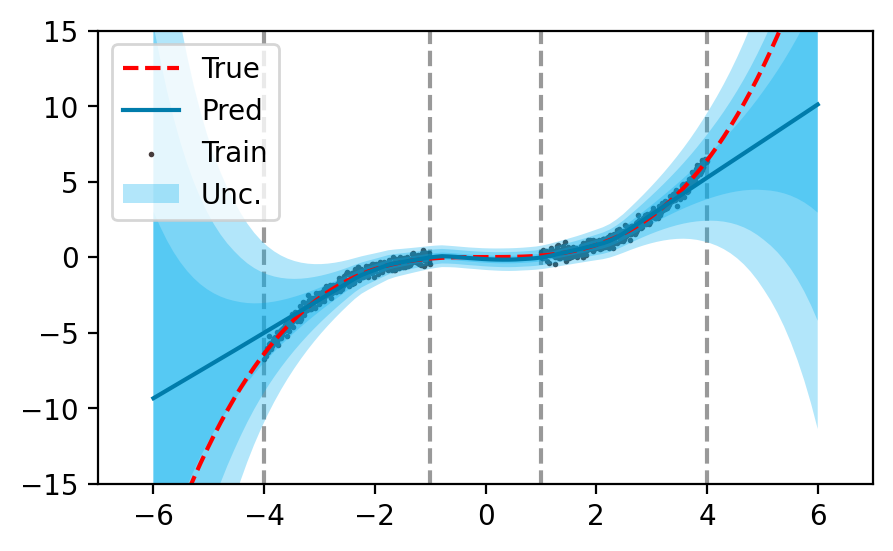

In [88]:
def plot_d1_results():
    true_x = np.linspace(-6, 6, 100)
    true_y = 0.1*true_x**3
    y_pred = d1_model(torch.from_numpy(true_x).float().unsqueeze(-1)).detach()

    n_stds = 4
    kk = 0
    x_train = torch.from_numpy(x_train_d1)
    y_train = torch.from_numpy(y_train_d1)
    x_test = true_x.reshape(true_x.shape[0], 1)
    y_test = torch.from_numpy(true_y)
    x_test = x_test[:, 0]
    mu, v, alpha, beta = y_pred
    
    var = np.sqrt(beta / (v * (alpha - 1)))
    var = np.minimum(var, 1e3)  # for visualization

    plt.figure(figsize=(5, 3), dpi=200)
    plt.scatter(x_train, y_train, s=1., c='#463c3c', zorder=0, label="Train")
    plt.plot(x_test, y_test, 'r--', zorder=2, label="True")
    plt.plot(x_test, mu, color='#007cab', zorder=3, label="Pred")
    plt.plot([-4, -4], [-150, 150], 'k--', alpha=0.4, zorder=0)
    plt.plot([-1, -1], [-150, 150], 'k--', alpha=0.4, zorder=0)
    plt.plot([1, 1], [-150, 150], 'k--', alpha=0.4, zorder=0)
    plt.plot([+4, +4], [-150, 150], 'k--', alpha=0.4, zorder=0)
    for k in np.linspace(0, n_stds, 4):
        plt.fill_between(
            x_test, (mu - k * var), (mu + k * var),
            alpha=0.3,
            edgecolor=None,
            facecolor='#00aeef',
            linewidth=0,
            zorder=1,
            label="Unc." if k == 0 else None)
    plt.gca().set_ylim(-15, 15)
    plt.gca().set_xlim(-7, 7)
    plt.legend(loc="upper left")
plot_d1_results()

## Dataset 2

In [9]:
def generate_d2():
    mu1, mu2, mu3 = -4, 0, 4
    std1, std2, std3 = 2/5, 0.9, 2/5
    x_train = np.concatenate([
        np.random.normal(loc=mu1, scale=std1, size=200),
        np.random.normal(loc=mu2, scale=std2, size=200),
        np.random.normal(loc=mu3, scale=std3, size=200)
    ])
    x_test = np.concatenate([
        np.random.normal(loc=mu1, scale=std1, size=50),
        np.random.normal(loc=mu2, scale=std2, size=50),
        np.random.normal(loc=mu3, scale=std3, size=50)
    ])
    noise = np.random.normal(scale=1, size=600)
    y_train = 7 * np.sin(x_train) + 3 * np.abs(np.cos(x_train/2)) * noise
    y_test = 7 * np.sin(x_test) + 3 * np.abs(np.cos(x_test/2))
    return (x_train, y_train), (x_test, y_test)

In [10]:
(x_train_d2, y_train_d2), (x_test_d2, y_test_d2) = generate_d2()

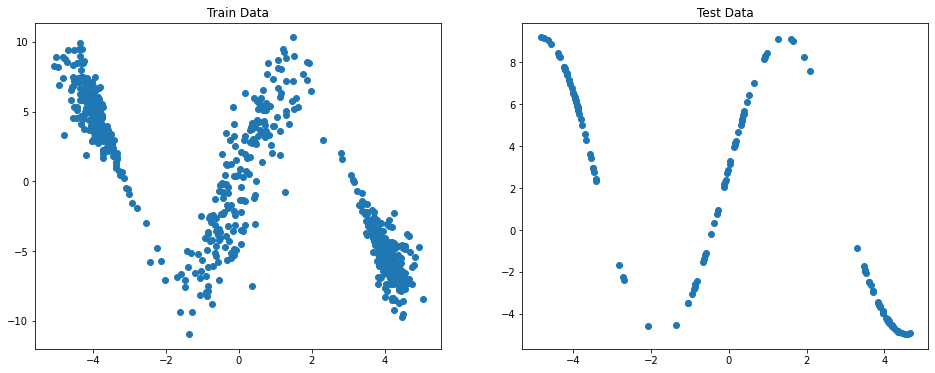

In [11]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

ax1.scatter(x_train_d2, y_train_d2)
ax1.set_title("Train Data")

ax2.scatter(x_test_d2, y_test_d2)
ax2.set_title("Test Data")

plt.show()

In [109]:
d2_model = EvidentialRegression(1, num_layers=2, num_neurons=20)
d2_trainer = EvidentialTrainer(d2_model, learning_rate=learning_rate)
rmse, nll = d2_trainer.train(
    torch.from_numpy(x_train_d2).unsqueeze(-1).float(),
    torch.from_numpy(y_train_d2).float(),
    torch.from_numpy(x_test_d2).unsqueeze(-1).float(),
    torch.from_numpy(y_test_d2).float(),
    1,
    iters=5000,
    batch_size=batch_size,
    verbose=True
)

[0]  RMSE: 5.2257 	 NLL: 4.7679 	 loss: 4.7855 	 reg_loss: 13.3321 	 lambda: 0.00
[100]  RMSE: 4.0854 	 NLL: 2.9936 	 loss: 3.4384 	 reg_loss: 5.1730 	 lambda: 0.09
[200]  RMSE: 3.4913 	 NLL: 2.6855 	 loss: 3.2309 	 reg_loss: 4.1396 	 lambda: 0.13
[300]  RMSE: 3.2515 	 NLL: 2.5117 	 loss: 3.0657 	 reg_loss: 3.2743 	 lambda: 0.17
[400]  RMSE: 3.2515 	 NLL: 2.4892 	 loss: 3.0649 	 reg_loss: 2.8917 	 lambda: 0.20
[500]  RMSE: 3.1111 	 NLL: 2.4879 	 loss: 3.0803 	 reg_loss: 2.6293 	 lambda: 0.23
[600]  RMSE: 3.1111 	 NLL: 2.4607 	 loss: 3.1039 	 reg_loss: 2.5697 	 lambda: 0.25
[700]  RMSE: 3.0902 	 NLL: 2.3489 	 loss: 2.9958 	 reg_loss: 2.3681 	 lambda: 0.27
[800]  RMSE: 2.9532 	 NLL: 2.2861 	 loss: 2.9452 	 reg_loss: 2.2363 	 lambda: 0.30
[900]  RMSE: 2.8352 	 NLL: 2.2432 	 loss: 2.9114 	 reg_loss: 2.1219 	 lambda: 0.32
[1000]  RMSE: 2.5039 	 NLL: 2.2432 	 loss: 3.0585 	 reg_loss: 2.0507 	 lambda: 0.34
[1100]  RMSE: 2.1617 	 NLL: 2.1395 	 loss: 2.7435 	 reg_loss: 1.7233 	 lambda: 0.35
[12

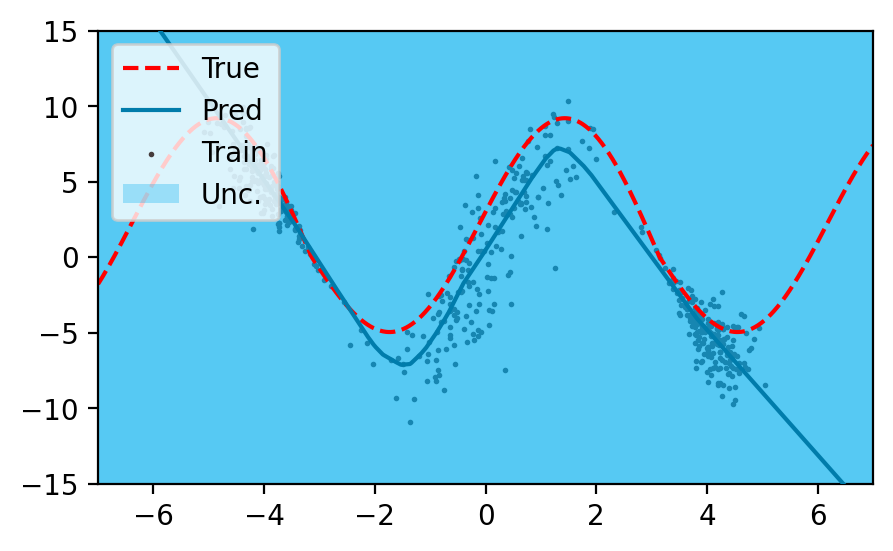

In [115]:
def plot_d2_results():
    true_x = np.linspace(-7, 7, 1000)
    true_y = 7 * np.sin(true_x) + 3 * np.abs(np.cos(true_x/2))
    y_pred = d2_model(torch.from_numpy(true_x).float().unsqueeze(-1)).detach()

    n_stds = 4
    kk = 0
    x_train = torch.from_numpy(x_train_d2)
    y_train = torch.from_numpy(y_train_d2)
    x_test = true_x.reshape(true_x.shape[0], 1)
    y_test = torch.from_numpy(true_y)
    x_test = x_test[:, 0]
    mu, v, alpha, beta = y_pred
    var = np.sqrt(beta / (v * (alpha - 1)))
    var = np.minimum(var, 1e3)  # for visualization

    plt.figure(figsize=(5, 3), dpi=200)
    plt.scatter(x_train, y_train, s=1., c='#463c3c', zorder=0, label="Train")
    plt.plot(x_test, y_test, 'r--', zorder=2, label="True")
    plt.plot(x_test, mu, color='#007cab', zorder=3, label="Pred")

    for k in np.linspace(0, n_stds, 4):
        plt.fill_between(
            x_test, (mu - k * var), (mu + k * var),
            alpha=0.3,
            edgecolor=None,
            facecolor='#00aeef',
            linewidth=0,
            zorder=1,
            label="Unc." if k == 0 else None)
    plt.gca().set_ylim(-15, 15)
    plt.gca().set_xlim(-7, 7)
    plt.legend(loc="upper left")
plot_d2_results()

## Dataset 3

In [14]:
def generate_d3():
    s1, e1 = 0, 0.5
    s2, e2 = 1.5, 2
    lambd = 1/3
    x_train = np.concatenate([np.linspace(s1, e1, 400), np.linspace(s2, e2, 400)])
    x_test = np.concatenate([np.linspace(s1, e1, 100), np.linspace(s2, e2, 100)])
    noise = np.random.exponential(scale=lambd, size=800)
    y_train = np.sin(2*np.pi*x_train) + noise
    y_test = np.sin(2*np.pi*x_test)
    return (x_train, y_train), (x_test, y_test)

In [15]:
(x_train_d3, y_train_d3), (x_test_d3, y_test_d3) = generate_d3()

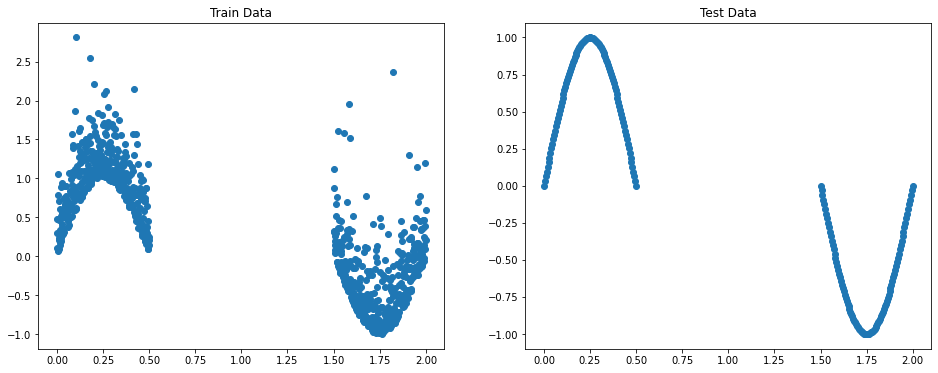

In [16]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

ax1.scatter(x_train_d3, y_train_d3)
ax1.set_title("Train Data")

ax2.scatter(x_test_d3, y_test_d3)
ax2.set_title("Test Data")

plt.show()

In [111]:
d3_model = EvidentialRegression(1)
d3_trainer = EvidentialTrainer(d3_model, learning_rate=learning_rate)
rmse, nll = d3_trainer.train(
    torch.from_numpy(x_train_d3).unsqueeze(-1).float(),
    torch.from_numpy(y_train_d3).float(),
    torch.from_numpy(x_test_d3).unsqueeze(-1).float(),
    torch.from_numpy(y_test_d3).float(),
    1,
    iters=10000,
    batch_size=batch_size,
    verbose=True
)

[0]  RMSE: 0.6685 	 NLL: 1.2921 	 loss: 1.2924 	 reg_loss: 1.5596 	 lambda: 0.00
[100]  RMSE: 0.4601 	 NLL: 0.7249 	 loss: 0.7542 	 reg_loss: 1.7035 	 lambda: 0.02
[200]  RMSE: 0.4601 	 NLL: 0.7249 	 loss: 0.8112 	 reg_loss: 1.6876 	 lambda: 0.03
[300]  RMSE: 0.4377 	 NLL: 0.6349 	 loss: 0.6999 	 reg_loss: 1.3625 	 lambda: 0.05
[400]  RMSE: 0.3928 	 NLL: 0.5355 	 loss: 0.6026 	 reg_loss: 1.1132 	 lambda: 0.06
[500]  RMSE: 0.3928 	 NLL: 0.5355 	 loss: 0.7820 	 reg_loss: 1.1644 	 lambda: 0.07
[600]  RMSE: 0.3928 	 NLL: 0.5355 	 loss: 0.7902 	 reg_loss: 1.0574 	 lambda: 0.08
[700]  RMSE: 0.3928 	 NLL: 0.5355 	 loss: 0.8167 	 reg_loss: 0.9854 	 lambda: 0.09
[800]  RMSE: 0.3928 	 NLL: 0.5355 	 loss: 0.6864 	 reg_loss: 0.8136 	 lambda: 0.10
[900]  RMSE: 0.3928 	 NLL: 0.5272 	 loss: 0.5988 	 reg_loss: 0.6842 	 lambda: 0.11
[1000]  RMSE: 0.3928 	 NLL: 0.5272 	 loss: 0.7495 	 reg_loss: 0.7467 	 lambda: 0.11
[1100]  RMSE: 0.3430 	 NLL: 0.4158 	 loss: 0.4777 	 reg_loss: 0.5314 	 lambda: 0.12
[120

[9800]  RMSE: 0.2388 	 NLL: 0.1479 	 loss: 0.3549 	 reg_loss: 0.2495 	 lambda: 0.39
[9900]  RMSE: 0.2388 	 NLL: 0.1479 	 loss: 0.4456 	 reg_loss: 0.2682 	 lambda: 0.39


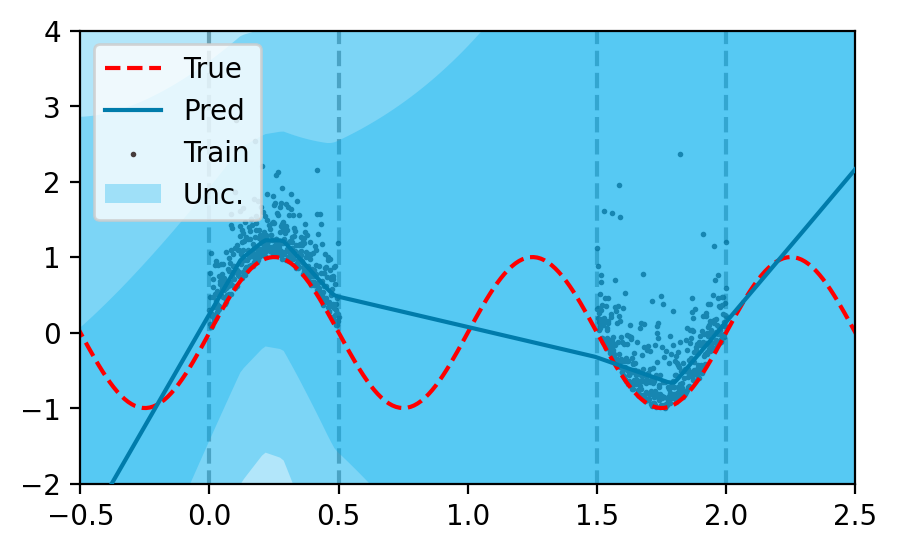

In [112]:
def plot_d3_results():
    true_x = np.linspace(-7, 7, 1000)
    true_y = np.sin(2*np.pi*true_x)
    y_pred = d3_model(torch.from_numpy(true_x).float().unsqueeze(-1)).detach()

    n_stds = 4
    kk = 0
    x_train = torch.from_numpy(x_train_d3)
    y_train = torch.from_numpy(y_train_d3)
    x_test = true_x.reshape(true_x.shape[0], 1)
    y_test = torch.from_numpy(true_y)
    x_test = x_test[:, 0]
    mu, v, alpha, beta = y_pred
    var = np.sqrt(beta / (v * (alpha - 1)))
    var = np.minimum(var, 1e3)  # for visualization

    plt.figure(figsize=(5, 3), dpi=200)
    plt.scatter(x_train, y_train, s=1., c='#463c3c', zorder=0, label="Train")
    plt.plot(x_test, y_test, 'r--', zorder=2, label="True")
    plt.plot(x_test, mu, color='#007cab', zorder=3, label="Pred")
    plt.plot([0, 0], [-150, 150], 'k--', alpha=0.4, zorder=0)
    plt.plot([0.5, 0.5], [-150, 150], 'k--', alpha=0.4, zorder=0)
    plt.plot([1.5, 1.5], [-150, 150], 'k--', alpha=0.4, zorder=0)
    plt.plot([2, 2], [-150, 150], 'k--', alpha=0.4, zorder=0)
    for k in np.linspace(0, n_stds, 4):
        plt.fill_between(
            x_test, (mu - k * var), (mu + k * var),
            alpha=0.3,
            edgecolor=None,
            facecolor='#00aeef',
            linewidth=0,
            zorder=1,
            label="Unc." if k == 0 else None)
    plt.gca().set_ylim(-2, 4)
    plt.gca().set_xlim(-0.5, 2.5)
    plt.legend(loc="upper left")
plot_d3_results()